# Testing for forecasting models

Testing a standard prediction model can be done using cross-validation. Usually we don't need to worry about ordering over observations so we can just go ahead and divide the data into K folds. However, we time-series data we need to take care to account for the chronological ordering of observations!

We can account for the chronological ordering by making sure that we only use past observations when making predictions (this also makes it realistic in a production setting!).

The remainder of this notebook will load some data and then show you how you can test a forecasting model!

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.api import tsa
from dateutil.parser import parse

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def parse_quarter(string):
    """
    Converts a string from the format YYYYQN in datetime object at the end of quarter N.
    """
    
    # Note: you could also just retrieve the first four elements of the string
    # and the last one... Regex is fun but often not necessary
    year, qn = re.search(r'^(20[0-9][0-9])(Q[1-4])$', string).group(1, 2)
    
    # year and qn will be strings, pd.datetime expects integers.
    year = int(year)
    
    date = None
    
    if qn=='Q1':
        date = pd.datetime(year, 3, 31)
    elif qn=='Q2':
        date = pd.datetime(year, 6, 30)
    elif qn=='Q3':
        date = pd.datetime(year, 9, 20)
    else:
        date = pd.datetime(year, 12, 31)
        
    return date


alcohol_consumption = pd.read_csv('data/NZAlcoholConsumption.csv', 
                                  parse_dates=['DATE'], 
                                  date_parser=parse_quarter,
                                  index_col='DATE')
alcohol_consumption.sort_index(inplace=True)

In [2]:
wine = alcohol_consumption.TotalWine
wine_diff = wine.diff(4).dropna()

time_series = wine_diff

## Forecasting

Until now we have tuned the model to *fit* the time series. 
This makes us able to find a description of the data, but doesn't give forecast.

**Note**: forecasting with time series data is **tricky** and usually basic methods do not really provide very good results (especially on realistic data). ARMA models are nice because they are simple but do not expect fantastic performances. (On the other hand, predicting the future is hard! -- who would have thought).

* Separate the time series into a training set and a test set formed of the last 8 points. 
* Fit an AR model on the training data and try to find the optimal lag using the `BIC` criterion
* fit the model, predict and show the prediction on the original time series. Did it do a good job? 
* compute the MAE

/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Out of sample MAE = 0.273


/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


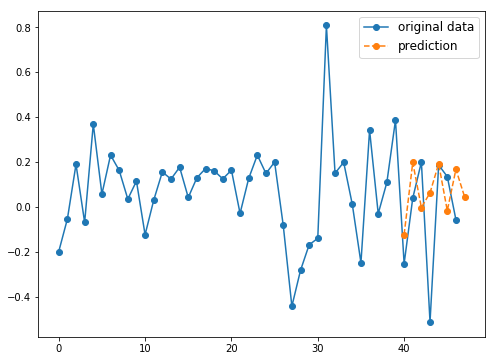

In [3]:
# divide data into training and testing:
train = time_series[:-8]
test = time_series[-8:]

# fit our AR model using the tsa module! 
ar = tsa.AR(train)

# choose the optimal lag using BIC (this is a model selection criterion, dont worry if you dont know what it is :))
optlag = ar.select_order(10, ic='bic', method='mle')

# now we fit our model with the chosen optimal lag:
arfit = ar.fit(maxlag=optlag)

# we make predictions on unseen data:
prediction = arfit.predict(end=len(time_series))[-len(test):]

# produce some figures:
plt.figure(figsize=(8, 6))
plt.plot(time_series.values, '-o', label="original data")
plt.plot(prediction, '--o', label='prediction')

plt.legend(fontsize=12)

print('Out of sample MAE = {0:.3f}'.format(mean_absolute_error(test, prediction)))


## Cross-Validation for Time Series Forecasting (demo)

Recall that it is important not to use future observations during a forecast! Below we will define a function to take a certain number of observations (ordered chronologically) as training data and use the remainder as testing data. We will also visualize their predictions :) 



In [4]:
def Forecasting_crossValidation( time_series, training_size ):
    """
    Given a pd.Series we train a autoregressive model. 
    The number of training observation is specified by the variable training_size
    """
    train = time_series[:training_size]
    test = time_series[training_size:]
    ar = tsa.AR(train)
    ar_result = ar.fit(maxlag=4)
    prediction = ar_result.predict(end=len(time_series))[-len(test):]
    
    # compute the MAE:
    mae = mean_absolute_error(time_series.values[training_size:], prediction)
    print('Mean absolute error: ' + str(mae))
    
    # plot results as well:
    plt.plot(time_series.values, '-o', label='true')
    plt.plot(range(training_size, len(time_series)), prediction, 
         '-o', label='out of sample prediction')
    plt.legend();
    
    return prediction
    

In [7]:
from ipywidgets import interact
def cv(x):
    Forecasting_crossValidation( time_series, x);
    
interact(cv, x=(5,45));
    

interactive(children=(IntSlider(value=25, description='x', max=45, min=5), Output()), _dom_classes=('widget-in…

#### Excercise:
 - compute the average mean absolute error (MAE) for all possible forecasts (using a minimum of 20 training points). Hint: you may need to change your function to _return_ the MAE, and then loop over all different sizes of training sets :) 
 
 
#### Note:
We may notice that the performance AR models isn't very good (at least visually it seems the models do a poor job of predicting future observations. There are many reasons this may be the case, one of them is that the data may be _non-stationary_! Indeed, if you observe a plot of the time-series data, we see there are large jumps present from around the 25th measurement onwards (the variance increases). 

In [8]:
def Forecasting_mae( time_series, maxlag=4 ):
    """
    Given a pd.Series we train a autoregressive model. 
    The number of training observation is specified by the variable training_size
    """
    result = np.zeros(41)
    
    for i, training_size in enumerate(range(5,45)):
        train = time_series[:training_size]
        test = time_series[training_size:]
        ar = tsa.AR(train)
        ar_result = ar.fit(maxlag=maxlag)
        prediction = ar_result.predict(end=len(time_series))[-len(test):]
        mae = mean_absolute_error(time_series.values[training_size:], prediction)    
        result[i] = mae
    
    return np.mean(result)    

In [18]:
for j in range(1, 4):
    print("j = {:d}, mae = {:.2f}".format(j, Forecasting_mae(time_series, j)))

/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `star

j = 1, mae = 0.19
j = 2, mae = 102709.77
j = 3, mae = 0.33


/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/anaconda3/envs/cspark/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasti